In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import re
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from textwrap import wrap
import math
debug = False

def read_file(filename):
    
    scale = int(filename.split("/")[-1].split("-")[0])
    tile_count = int(filename.split("/")[-1].split("-")[1])
    with open(filename, 'r') as f:
        l = [[num for num in line.split(' ')][:-1] for line in f]

        lambda_vector = np.array(l[0]).astype('float64')
        q_vector = np.reciprocal(lambda_vector)*scale
        # q_vector = np.rint(q_vector)
        # q_vector = np.round(q_vector, 2)
        # q_vector = np.unique(q_vector)
        tau_vector = np.array(l[1]).astype('float64')
        Iqtau_mat = np.array(l[2:]).astype('float64')
    
    if debug:
        print(len(q_vector))
        print(len(tau_vector))
        print(Iqtau_mat.shape)

    return (lambda_vector, q_vector, tau_vector, Iqtau_mat, scale, tile_count)

def plot_Iqtau_heatmap(lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path):
    
    fig,ax = plt.subplots(1,1)

    im = ax.imshow(Iqtau_mat, cmap='hot', interpolation='nearest', aspect='auto', extent=[tau_vector[0],tau_vector[-1], q_vector[-1], q_vector[0]])
    # ax.set_yscale('log')

    # Where we want the ticks, in pixel locations
    xticks = tau_vector
    yticks = q_vector
    # What those pixel locations correspond to in data coordinates.
    # Also set the float format here
    xticklabels = ["{:6.2f}".format(i) for i in xticks]
    yticklabels = ["{:6.2f}".format(i) for i in yticks]

    plt.xlabel('tau(s)')
    plt.ylabel('q')
    fig.colorbar(im)
    
    plt.savefig(plot_path+'heatmap.jpg', bbox_inches='tight')
    plt.close()
    # plt.show()
    
def plot_Iqtau_tau(q_value, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path):
    
    try:    
        q_number = np.where(q_vector == q_value)[0][0]
    except:
        print("Failed to plot Iqtau_tau for a non-exsiting q="+str(q_value))
        return 
    
    plt.scatter(tau_vector, Iqtau_mat[q_number], s=6)
    plt.xlabel('tau(s)')
    plt.ylabel('Iqtau')
    plt.title('Iqtau-tau plot for q='+str(q_value))
    
    plt.savefig(plot_path+'Iqtau_tau_q='+str(q_value)+'.jpg', bbox_inches='tight')
    plt.close()
    # plt.show()

def plot_Iqtau_q(tau_number, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path):

    try:    
        tau_value = tau_vector[tau_number]
    except:
        print("Failed to plot Iqtau_tau for a non-exsiting tau_number="+str(tau_number))
        return 
    
    x = q_vector
    y = Iqtau_mat[:,tau_number]
    x_new = np.linspace(x.min(), x.max(),500)

    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    
    fig = plt.figure()
    ax = plt.gca()
    # ax.scatter(data['o_value'] ,data['time_diff_day'] , c='blue', alpha=0.05, edgecolors='none')
    ax.plot (x_new,y_smooth)
    ax.scatter (x, y, s=30, alpha=0.5)
    ax.set_xscale('log')

    # plt.plot (x_new,y_smooth)
    # plt.scatter (x, y, s=30, alpha=0.5)
    # plt.scatter(q_vector, Iqtau_mat[:,tau_number], s=30, alpha=0.5)
    plt.xlabel('q')
    plt.ylabel('Iqtau')
    plt.title('Iqtau-tau plot for tau='+str(tau_value)+'s')
    plt.savefig(plot_path+'Iqtau_q_tau='+str(tau_value)+'.jpg', bbox_inches='tight')
    plt.close()
    # plt.show()
    
def objective(x, A, v, x_c, B, C):
    return A * (1 - np.exp(np.cos(2*math.pi*v*x)))*np.exp(-x/x_c) + B*x + C
    # return A * (1 - np.cos(2*math.pi*v*x))*np.exp(-x/x_c) + B*x + C


In [14]:
def fit_and_plot(q_value, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path):
    
    try:    
        q_number = np.where(q_vector == q_value)[0][0]
    except:
        print("Failed to plot Iqtau_tau for a non-exsiting q="+str(q_value))
        return 
    
    # set tau_offset to be half period before the first local maximum
    try:
        first_max_ord = argrelextrema(Iqtau_mat[q_number], np.greater)[0][0]
        first_min_ord = argrelextrema(Iqtau_mat[q_number], np.less)[0][0]
        first_min_val = Iqtau_mat[q_number][first_min_ord]
        start_point_ord = (np.abs(Iqtau_mat[q_number][:first_max_ord] - first_min_val)).argmin()
        tau_offset = start_point_ord
    except:
        tau_offset = 0
        print("Unable to identify the first peak in Iqtau for q="+str(q_value)+', set tau_offset=0')
        
    x = tau_vector[tau_offset:]
    y = Iqtau_mat[q_number][tau_offset:]
    
    # estimate gradient and intercept
    B_init = (y[-1]-y[0])/(x[-1]-x[0])
    C_init = y[-1]-B_init*x[-1]
    
    # estimate the initial fitting params
    # estimate the period by local minimum
    try:
        y_local_max_ord = argrelextrema(y-B_init*x, np.greater)
        y_local_min_ord = argrelextrema(y-B_init*x, np.less)
        # y_local_max_ord = argrelextrema(y, np.greater)
        # y_local_min_ord = argrelextrema(y, np.less)
        if len(y_local_max_ord[0])>=2:
            T = (x[y_local_max_ord[0][1]]-x[y_local_max_ord[0][0]])
        else:
            T = 2*(x[y_local_min_ord[0][0]]-x[y_local_max_ord[0][0]])
    except:
        T = 2
        print("Unable to estimate oscillation period T, set T=2.")

    v_init = 1/T
    
    # initial parameters, A, v, x_c, B, C
    p0 = [1,v_init,1,B_init,C_init]
    
    # curve fit
    try:
        popt, _ = curve_fit(objective, x, y, p0)
    except:
        print("Failed to fit the Iqtau-tau curve")
        return (None, None, None, None, None, None, None)
        
    # summarize the parameter values
    A, v, x_c, B, C = popt
    # print('I(q,tau) = %.3f * (1 - np.exp(np.cos(2*math.pi*%.3f*tau)))*np.exp(-tau/%.3f) + %.3f*tau + %.3f' % (A,v,x_c,B,C))
    pred_y = objective(x, A, v, x_c, B, C)
    y_fit_error2 = np.mean(np.abs(y - pred_y)**2)
    y_fit_error2_per = y_fit_error2/np.mean(np.square(y))
    # plot input vs output
    plt.scatter(x, y, s=6)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.1)
    # calculate the output for the range
    y_line = objective(x_line, A, v, x_c, B, C)
    # create a line plot for the mapping function
    labels=['Measured I(q='+str(np.round(q_value,2))+',tau)',
        'I(q='+str(np.round(q_value,2))+',tau)'+'= {:.2f}(1-exp(cos(2pi*{:.2f}tau)))exp(-tau/{:.2f})+{:.2f}tau+{:.2f}'.format(A, v, x_c, B, C)]
    labels = [ '\n'.join(wrap(l, 41)) for l in labels ]
    plt.plot(x_line, y_line, '--', color='red')
    plt.xlabel('tau(s)')
    plt.ylabel('I(q='+str(np.round(q_value,2))+',tau)')
    plt.legend(labels)
    # plt.legend('','')
    
    plt.savefig(plot_path+'fit_Iqtau_tau_q='+str(q_value)+'.jpg', bbox_inches='tight')
    # plt.show()
    plt.close()

    return [q_value, A, v, x_c, B, C, y_fit_error2, y_fit_error2_per]

5
140
(5, 140)
[5. 3. 2. 1. 1.]


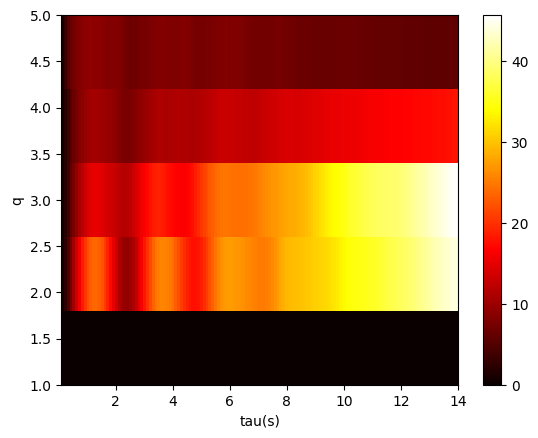

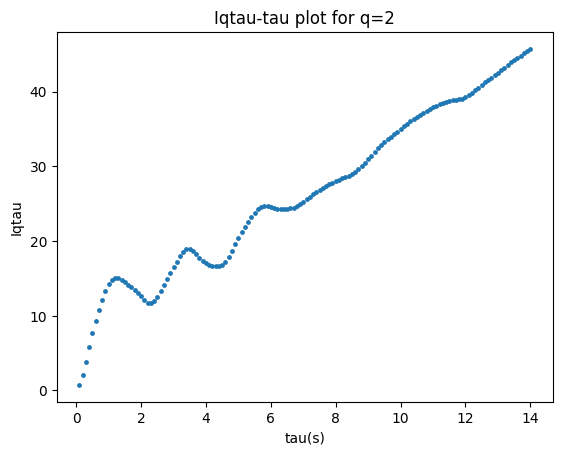

2.3
I(q,tau) = 4.440 * (1 - np.exp(np.cos(2*math.pi*0.438*tau)))*np.exp(-tau/3.686) + 2.609*tau + 8.378


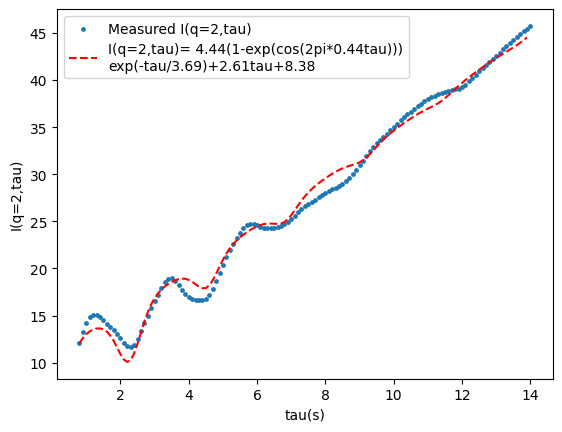

(4.439588870917736,
 0.43816482746805674,
 3.6863933878004116,
 2.609446079798359,
 8.378383249924383,
 0.7898125091421369,
 0.0009176611349437615)

In [ ]:
# filename = "/cicutagroup/yz655/cuda_run_result/0036/1024-0"
# filename = "/cicutagroup/yz655/cuda_run_result/nott_sample/1024-0"
# filename = "/cicutagroup/yz655/cuda_run_result/0050/64-20"
# filename = "/cicutagroup/yz655/cuda_run_result/single_channel_8bit_compressed_gray_DJI_0050/512-0"
# filename = "/cicutagroup/yz655/cuda_run_result/compressed_nottingham_sample_new/512-0"
# filename = "/cicutagroup/yz655/cuda_run_result/compressed_nottingham_sample_new/1024-0"
debug = True
filename = "/cicutagroup/yz655/cuda_run_result/drone/fps_10_trimmed_14s_WinterWheat1_2022-07-25-140826-0000_new/512-0"
# filename = "/cicutagroup/yz655/cuda_run_result/drone/fps_10_compressed_wheat_DJI_0050_al_20.8_fl_161_scale_7.74x/1024-0"
# filename = "/cicutagroup/yz655/cuda_run_result/multistream/fps_10_compressed_gray_DJI_0052/1024-0"
(q_vector, tau_vector, Iqtau_mat) = read_file(filename)
print(q_vector)
# lambda_v = 200
# q_value = 1024/lambda_v
q_value = 2
# lambda_value = round(1024/7,2)
tau_number = 60
plot_Iqtau_heatmap(q_vector, tau_vector, Iqtau_mat)
plot_Iqtau_tau(q_value, q_vector, tau_vector, Iqtau_mat)

# plot_Iqtau_q(tau_number,q_vector, tau_vector, Iqtau_mat)
fit_and_plot(q_value, q_vector, tau_vector, Iqtau_mat)


In [ ]:
# class FileResult:
#     def __init__(self, filename, q_vector, tau_vector, scale, tile_count, fit_result_arr):
#         self.filename = filename
#         self.q_vector = q_vector
#         self.tau_vector = tau_vector
#         # self.Iqtau_mat = Iqtau_mat
#         self.scale = scale
#         self.tile_count = tile_count
#         self.fit_result_arr = fit_result_arr

In [15]:
def analyse_video_result_file(filename):
    
    plot_path = filename+"_plot/"
    isExist = os.path.exists(plot_path)
    if not isExist:
        os.makedirs(plot_path)
    
    (lambda_vector, q_vector, tau_vector, Iqtau_mat, scale, tile_count) = read_file(filename)
    plot_Iqtau_heatmap(lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path)
    
    fit_result_arr=[]
    for q_value in q_vector:
        # if q_value==np.round(q_value,2):
        plot_Iqtau_tau(q_value, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path)
        fit = fit_and_plot(q_value, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path)
        fit_result_arr.append(fit)

    for tau_number in range(len(tau_vector)):
        if tau_number%10==0:
            if tau_number==0:
                plot_Iqtau_q(tau_number, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path) 
            else:
                plot_Iqtau_q(tau_number-1, lambda_vector, q_vector, tau_vector, Iqtau_mat, filename, plot_path) 
        
    # result = FileResult(filename, q_vector, tau_vector, scale, tile_count, fit_result_arr)
    result = {'filename': filename, 'q_vector': q_vector.tolist(), 'tau_vector': tau_vector.tolist(), 'scale': scale, 'tile_count': tile_count, 'fit_result_arr': fit_result_arr}
    
    return result
        

def analyse_video_result_folder(directoryname):
     
    directory = os.fsencode(directoryname)
    
    with open(directoryname+'result.txt', 'w') as fout:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            match = re.search(r'\d+$', filename)
            # if filename ends with an integer
            if match is not None:
                filename=directoryname+filename
                # print(filename)
                result = analyse_video_result_file(filename)
                # result_list.append(result)
                json.dump(result, fout)
                fout.write("\n")

In [ ]:
directoryname ="/cicutagroup/yz655/cuda_run_result/drone_even_lambda/compressed_fps10_gray_DJI_0050/"
analyse_video_result_folder(directoryname)

In [69]:
%%capture
directoryname ="/cicutagroup/yz655/cuda_run_result/drone/"
# analyse_video_result_folder(directoryname)

directory = os.fsencode(directoryname)

result_list = []
    
for folder in os.listdir(directory):
    folder=directoryname+folder.decode("utf-8")+'/'
    analyse_video_result_folder(folder)
        

Unable to identify the first peak in Iqtau for q=1.0, set tau_offset=0
Unable to estimate oscillation period T, set T=2.


In [26]:
#Read json result file
directoryname ="/cicutagroup/yz655/cuda_run_result/drone/compressed_fps10_gray_DJI_0050/"
result_path = directoryname+'result.txt'
  
# reading the data from the file
with open(result_path) as f:
    data = [json.loads(line) for line in f]
    # print(data)
  
# print("Data type before reconstruction : ", type(data))

tauc_dict={}

# [q_value, A, v, x_c, B, C, y_fit_error2, y_fit_error2_per]

for d in data:
    # if fit error percentage is less than threshold
    for fit in d['fit_result_arr']:
        if fit[-1]!=None and fit[-1]<=0.002:
            key = d['scale']
            if key not in tauc_dict:
                tauc_dict[key] = [1/fit[2]]
            else:
                tauc_dict[key].append(1/fit[2])

tauc_dict = dict(sorted(tauc_dict.items()))
value = tauc_dict.values()


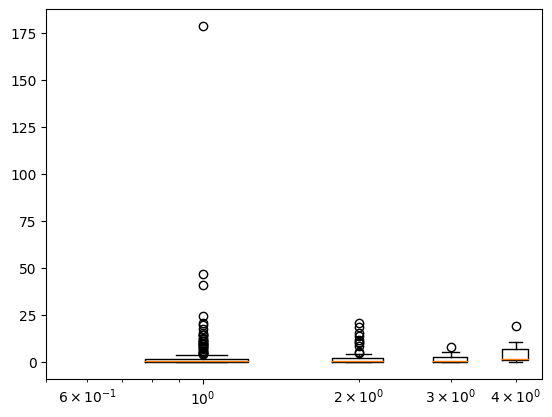

In [27]:
# fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(value)
plt.xscale('log')
 
# show plot
plt.show()

60
210
(60, 210)


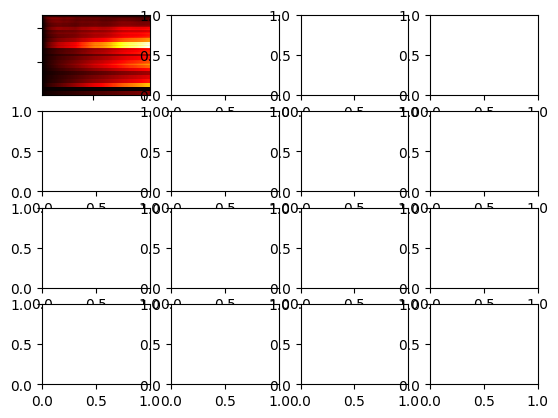

60
210
(60, 210)


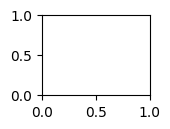

60
210
(60, 210)


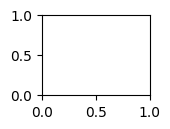

60
210
(60, 210)


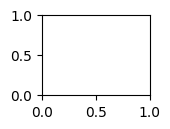

60
210
(60, 210)


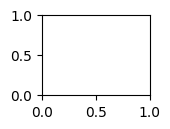

60
210
(60, 210)


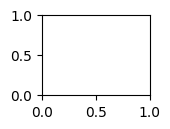

60
210
(60, 210)


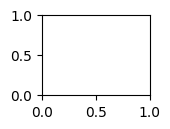

60
210
(60, 210)


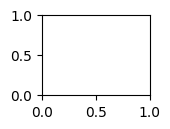

60
210
(60, 210)


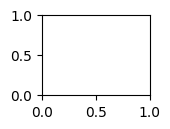

60
210
(60, 210)


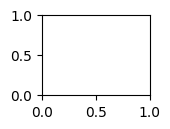

60
210
(60, 210)


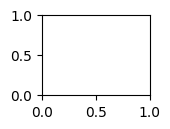

60
210
(60, 210)


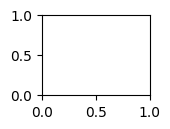

60
210
(60, 210)


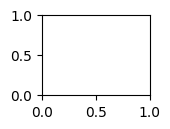

60
210
(60, 210)


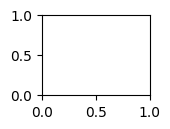

60
210
(60, 210)


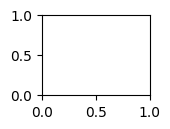

60
210
(60, 210)


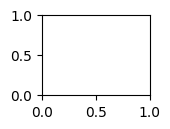

In [94]:
def plot_Iqtau_heatmap(q_vector, tau_vector, Iqtau_mat, row, col, count, axarr):
    

    im = axarr[row,col].imshow(Iqtau_mat, cmap='hot', interpolation='nearest', aspect='auto', extent=[tau_vector[0],tau_vector[-1],q_vector[0],q_vector[-1]])

    # Where we want the ticks, in pixel locations
    xticks = tau_vector
    yticks = q_vector
    # What those pixel locations correspond to in data coordinates.
    # Also set the float format here
    xticklabels = ["{:6.2f}".format(i) for i in xticks]
    yticklabels = ["{:6.2f}".format(i) for i in yticks]

    # plt.xlabel('tau(s)')
    # plt.ylabel('q')
    # fig.colorbar(im)
    plt.show()

# fig = plt.figure(figsize=(4,4)) # Notice the equal aspect ratio
# ax = [fig.add_subplot(4,4,i+1) for i in range(16)]
f, axarr = plt.subplots(4,4)

for row in range(4):
    for col in range(4):
        axarr[row,col].set_xticklabels([])
        axarr[row,col].set_yticklabels([])
        axarr[row,col].set_aspect('equal')
    
        count = row*4+col
        filename = "/cicutagroup/yz655/cuda_run_result/multistream/fps_10_compressed_gray_DJI_0051/256-"+str(count)
        (q_vector, tau_vector, Iqtau_mat) = read_file(filename)
        plt.subplot(4,4,count+1)
        plot_Iqtau_heatmap(q_vector, tau_vector, Iqtau_mat, row, col, count, axarr)
        
# axarr[0,0].imshow(image_datas[0])
# axarr[0,1].imshow(image_datas[1])
# axarr[1,0].imshow(image_datas[2])
# axarr[1,1].imshow(image_datas[3])

# for a in ax:
#     a.set_xticklabels([])
#     a.set_yticklabels([])
#     a.set_aspect('equal')

# fig.subplots_adjust(wspace=0, hspace=0)

# for i in range(16):
#     filename = "/cicutagroup/yz655/cuda_run_result/multistream/fps_10_compressed_gray_DJI_0051/256-"+str(i)
#     (q_vector, tau_vector, Iqtau_mat) = read_file(filename)
#     plot_Iqtau_heatmap(q_vector, tau_vector, Iqtau_mat, 4, 4, i)


# plot_Iqtau_heatmap(q_vector, tau_vector, Iqtau_mat)
# q_number = 40
# plot_Iqtau_tau(q_number, tau_vector, Iqtau_mat)
# tau_number = 60
# plot_Iqtau_q(q_vector, tau_number, Iqtau_mat)
# fit_and_plot(q_number, tau_vector, Iqtau_mat, tau_offset=18)

In [8]:
import numpy as np

path = "/cicutagroup/yz655/cuda_run/"

upper_scale = 10   # 2^10
lower_scale = 10

upper_q = 500   # m-1
lower_q = 5
q_number = 100

upper_tau = 140  # frame number. tau count should be less than 1/3 of the total video frame
lower_tau = 1
tau_gap = 1



q_list = np.linspace(lower_q, upper_q, num=q_number)
# print(q_list)
lambda_list = 2**upper_scale*np.reciprocal(q_list)
# print(lambda_list)
lambda_list = np.flip(lambda_list)
print(lambda_list)
# lambda_list = np.reciprocal(q_list)

[  2.048        2.06868687   2.08979592   2.11134021   2.13333333
   2.15578947   2.1787234    2.20215054   2.22608696   2.25054945
   2.27555556   2.3011236    2.32727273   2.35402299   2.38139535
   2.40941176   2.43809524   2.46746988   2.49756098   2.52839506
   2.56         2.59240506   2.62564103   2.65974026   2.69473684
   2.73066667   2.76756757   2.80547945   2.84444444   2.88450704
   2.92571429   2.96811594   3.01176471   3.05671642   3.1030303
   3.15076923   3.2          3.25079365   3.30322581   3.35737705
   3.41333333   3.47118644   3.53103448   3.59298246   3.65714286
   3.72363636   3.79259259   3.86415094   3.93846154   4.01568627
   4.096        4.17959184   4.26666667   4.35744681   4.45217391
   4.55111111   4.65454545   4.7627907    4.87619048   4.99512195
   5.12         5.25128205   5.38947368   5.53513514   5.68888889
   5.85142857   6.02352941   6.20606061   6.4          6.60645161
   6.82666667   7.06206897   7.31428571   7.58518519   7.87692308
   8.192   